In [1]:
import pandas as pd
import numpy as np
import re
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA, FactorAnalysis, KernelPCA
from sklearn.cluster import MeanShift
import urlmarker
import matplotlib.pyplot as plt

In [2]:
subs = pd.read_csv('subscriptions.csv')
train = subs.sample(frac=.5, random_state=1111)
test = subs[~subs.index.isin(train.index)]

In [3]:
def bps_encode(bps_value):
    """Returns an encoding for an input bps value."""
    encoder = {
        'Content': 0,
        '+Optimize': 1,
        '+Photo': 2,
        'BlogMutt Complete': 3
    }
    return encoder[bps_value]

def info_count(other_info):
    """Takes other info field and returns number characters."""
    if isinstance(other_info, type(float())):
        return 0
    return len(other_info)

def url_finder(other_info):
    """Takes other info field and looks for url. Returns 0 or 1."""
    try:
        result = bool(re.findall(urlmarker.WEB_URL_REGEX, other_info))
    except:
        return 0
    if result:
        return 1
    else:
        return 0
    
def is_annual(plan_name):
    """Parses plan name to see if annual or not"""
    if 'Annual' in plan_name:
        return 1
    else:
        return 0
    
def is_content(plan_name):
    """Parses plan name to see if basic or content"""
    if 'Basic' in plan_name:
        return 0
    elif 'Content' in plan_name:
        return 1
    else:
        print('Unable to parse plan name: ', plan_name)
        raise Exception
        
def encode_state(state):
    """Encodes state with a value"""
    encoder = {
        'active':0,
        'pending':1,
        'expired':2,
        'canceled':3
    }
    return encoder[state]

def to_numeric(df):
    """Takes the subs dataframe and returns the numeric version."""
    cols = [
        'id', 
        'bps_plan', 
        'submitted_posts', 
        'purchased_posts', 
        'declined_posts', 
        'info_chars', 
        'has_url', 
        'plan_words', 
        'annual', 
        'content',
        'preferred_writers', 
        'state', 
        'lt_days'
    ]
    fts = pd.DataFrame(columns=cols)
    fts['id'] = df.id
    fts['bps_plan'] = df['bps_plan'].apply(bps_encode)
    fts['submitted_posts'] = df.submitted_posts
    fts['purchased_posts'] = df.purchased_posts
    fts['declined_posts'] = df.declined_posts
    fts['info_chars'] = df.other_info.apply(info_count)
    fts['has_url'] = df.other_info.apply(url_finder)
    fts['plan_words'] = df.plan_words
    fts['annual'] = df.plan_name.apply(is_annual)
    fts['content'] = df.plan_name.apply(is_content)
    fts['preferred_writers'] = df.preferred_writers
    fts['state'] = df.state.apply(encode_state)
    fts['lt_days'] = df.current_lifetime_days
    return fts

In [4]:
subs_fts = to_numeric(subs)
ft_cols = [ 
        'bps_plan', 
        'submitted_posts', 
        'purchased_posts', 
        'declined_posts', 
        'info_chars', 
        'has_url', 
        'plan_words', 
        'annual', 
        'content',
        'preferred_writers', 
        'state', 
        'lt_days'
]
fts = subs_fts[ft_cols].values

In [5]:
X_train = to_numeric(train)
X_test = to_numeric(test)
scaler = StandardScaler()
X_tr = scaler.fit_transform(X_train)
X_te = scaler.transform(X_test)

In [6]:
kpca = KernelPCA(kernel='rbf', n_components=25, fit_inverse_transform=True)
X = kpca.fit_transform(X_tr)
X_ = kpca.transform(X_te)

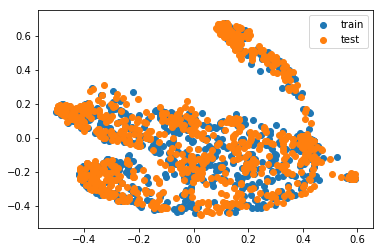

In [7]:
plt.scatter(X[:, 0], X[:, 1], label='train')
plt.scatter(X_[:, 0], X_[:, 1], label='test')
plt.legend();
plt.show();

cluster cluster 0 (train) size: 469
cluster cluster 0 (test) size: 437
cluster cluster 1 (train) size: 268
cluster cluster 1 (test) size: 258
cluster cluster 2 (train) size: 106
cluster cluster 2 (test) size: 147
cluster cluster 3 (train) size: 37
cluster cluster 3 (test) size: 37


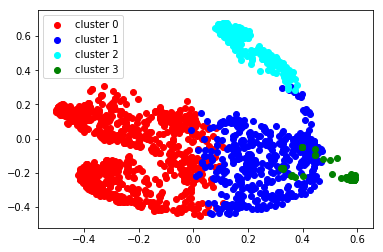

In [8]:
mns = MeanShift(bandwidth=.7)
clusts = mns.fit_predict(X)
clusts_ = mns.predict(X_)
colors = ['red', 'blue', 'cyan', 'green', 'orange']
for clust in range(len(np.unique(clusts))):
    name = 'cluster {}'.format(clust)
    members = np.where(clusts==clust, True, False)
    print('cluster {} (train) size:'.format(name), np.where(members, 1, 0).sum())
    plt.scatter(X[members, 0], X[members, 1], label=name, color=colors[clust])
    members = np.where(clusts_==clust, True, False)
    print('cluster {} (test) size:'.format(name), np.where(members, 1, 0).sum())
    plt.scatter(X_[members, 0], X_[members, 1], color=colors[clust])
    
plt.legend();
plt.show();

In [9]:
train['cluster'] = clusts
test['cluster'] = clusts_

/home/ubuntu/anaconda3/envs/mklear/lib/python3.6/site-packages/ipykernel/__main__.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  from ipykernel import kernelapp as app


In [10]:
df = pd.concat([train, test], axis=0)
df = df.sort_index().copy()
df['days_writer'] = np.where(df.preferred_writers>0, df.current_lifetime_days/df.preferred_writers, 0)
df['posts/day'] = np.where(df.current_lifetime_days > 0, df.submitted_posts/df.current_lifetime_days, 0)
df['has_url'] = X_train.has_url
df['has_url'] = X_test.has_url
df['info_chars'] = X_train.info_chars
df['info_chars'] = X_test.info_chars
df['accept_rate'] = df.decline_rate * (-1) + 1

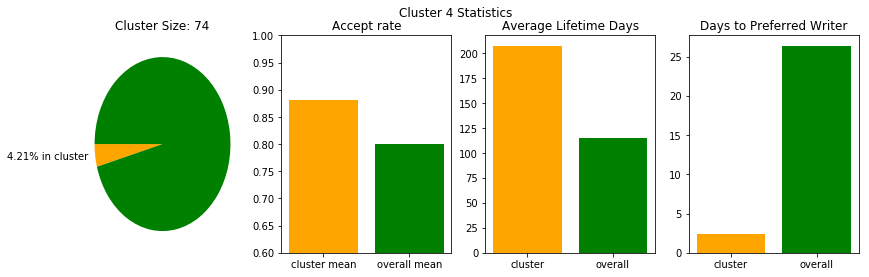

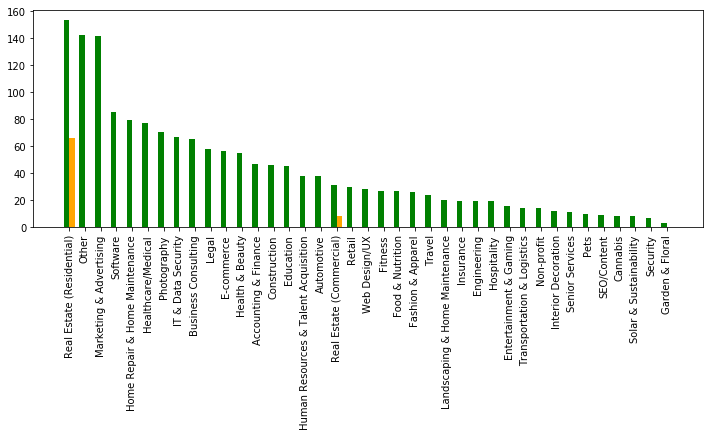

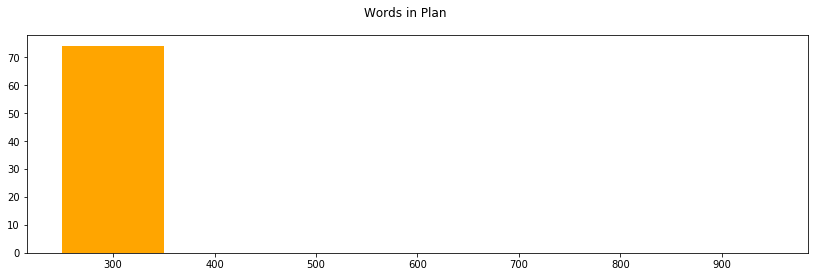

In [36]:
-
describe_cluster(df, 3)

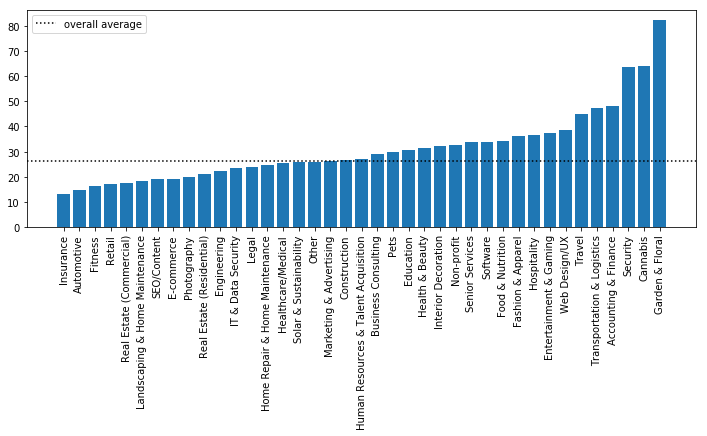

In [55]:
def plot_days_industry(df):
    """Breaks down the average number of days to acquire 
    a new preferred writer by industry
    """
    fig, ax = plt.subplots(figsize=(12, 4))
    mn = df.days_writer.mean()
    ax.axhline(y=mn, color='black', linestyle='dotted', label='average ({})'.format(round(mn,3)))
    industries = []
    means = []
    for ind in df.primary_industry.unique():
        industries.append(ind)
        if pd.isnull(ind):
            industries[-1] = 'n/a'
        means.append(df[df.primary_industry==ind].days_writer.mean())
    org_df = pd.DataFrame()
    org_df['mean_'] = means
    org_df['industry'] = industries
    org_df = org_df.sort_values('mean_', ascending=True)
    idx = list(org_df.index)[-1]
    org_df.drop(idx, inplace=True)
    ax.bar(org_df.industry, org_df.mean_)
    ax.set_xticklabels(org_df.industry, rotation=90)
    plt.legend();
    plt.show();
    return

plot_days_industry(df)

In [ ]:
x = []
y = []
for clust in df.cluster.unique():
    x.append('cluster {}'.format(clust))
    #y.append(df[df.cluster==clust].decline_rate.mean())
    y.append(len(df[df.cluster==clust]))
    
plt.bar(x, y)
    

In [ ]:
df[df.cluster==2].days_writer.mean()

In [ ]:
X_train.columns

In [ ]:
df['has_url'] = X_train.has_url
df['has_url'] = X_test.has_url
df['info_chars'] = X_train.info_chars
df['info_chars'] = X_test.info_chars

In [ ]:
for clust in np.unique(clusts):
    name = 'cluster {}'.format(clust)
    members = np.where(clusts==clust, True, False)
    cluster = X[members, :]
    mean_value = cluster.mean(axis=0)
    to_std = kpca.inverse_transform(mean_value.reshape(1, -1))
    to_numeric = scaler.inverse_transform(to_std)
    print(revert_to_features(to_numeric))
    break
    